# Analise modelos ML

## Carregar dados tratados

In [17]:
# ! pip install seaborn
# ! pip install plotly
# ! pip install statsmodels
# ! pip install sklearn

In [18]:
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score

import joblib

In [19]:
def carregar_joblib(file_name: str = "../out/result_analise_desc_scaled.joblib"):
    df = joblib.load(file_name)
    return df

## Feature selection

In [20]:
def print_feature_selection_extra_trees(df):
    modelo = ExtraTreesClassifier(random_state=1)
    x = df.drop("decisao", axis=1)
    y = df["decisao"]
    modelo.fit(x, y)

    caracteristicas_importantes = pd.DataFrame(modelo.feature_importances_, x.columns).sort_values(by=0, ascending=False)
    print(caracteristicas_importantes)

In [21]:
def ajustar_scaler(tabela_original):
    scaler = StandardScaler()
    tabela_auxiliar = tabela_original.drop("decisao", axis=1)
    
    tabela_auxiliar = pd.DataFrame(scaler.fit_transform(tabela_auxiliar), tabela_auxiliar.index, tabela_auxiliar.columns)
    tabela_auxiliar["decisao"] = tabela_original["decisao"]
    
    return tabela_auxiliar


In [22]:
def split_dados(df):
    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=1)

    print(f"{len(X_treino)=} {len(X_teste)=} {len(y_treino)=} {len(y_teste)=}")

    return X_treino, X_teste, y_treino, y_teste

## Dummy selection para avaliar uma selecao randomica de compra e venda

In [23]:
def run_dummy_classifier(
    X_treino,
    X_teste, 
    y_treino
):
    dummy = DummyClassifier(strategy="stratified", random_state=2)
    dummy.fit(X_treino, y_treino)
    previsao_dummy = dummy.predict(X_teste)
    
    return previsao_dummy

In [24]:
def avaliar(y_teste, previsoes, nome_modelo):
    print(nome_modelo)
    print("Reporte teste")
    report = classification_report(y_teste, previsoes)
    print(report)
    cf_matrix = pd.DataFrame(confusion_matrix(y_teste, previsoes), index=["Vender", "Comprar"], columns=["Vender", "Comprar"])
    sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt=',')
    plt.show()
    print("#" * 50)
    
    


# ML modelos

## Modelos a serem testados

- AdaBoost
- Decision Tree
- Random Forest
- ExtraTree
- Gradient Boost
- K Nearest Neighbors (KNN)
- Logistic Regression
- Rede Neural

In [41]:
def definir_modelos_ml() -> dict:
    return {
        # "AdaBoost": AdaBoostClassifier(random_state=1),
        "DecisionTree": DecisionTreeClassifier(random_state=1),
        # "RandomForest": RandomForestClassifier(random_state=1),
        # "ExtraTree": ExtraTreesClassifier(random_state=1),
        # "GradientBoost": GradientBoostingClassifier(random_state=1),
        # "KNN": KNeighborsClassifier(),
        # "LogisticRegression": LogisticRegression(C=1.0, max_iter=100, tol=0.0001, random_state=1, solver="newton-cg",
        #                         fit_intercept=True, intercept_scaling=1, l1_ratio=None, penalty="none", warm_start=False),
        # # "LogisticRegression": LogisticRegression(C=1.0, max_iter=100, tol=0.0001, random_state=1, solver="newton-cg"),
        "RedeNeural": MLPClassifier(solver= "sgd", random_state= 2, hidden_layer_sizes= 5),
    }



In [26]:
def rodar_imprimir_modelos_ml(modelos, X_treino, X_teste, y_treino, y_teste):
    for nome_modelo in modelos:
        modelo = modelos[nome_modelo]
        modelo.fit(X_treino, y_treino)
        previsoes = modelo.predict(X_teste)
        avaliar(y_teste, previsoes, nome_modelo)
        modelos[nome_modelo] = modelo
    
    return modelos

# Execucao

In [27]:
def main(scaled: bool):
    if scaled:
        df = carregar_joblib("../out/result_analise_desc_scaled.joblib")
        print("scaled df")
    else:
        df = carregar_joblib()
        print("NOT scaled df")

    print(df.shape)

    print("Feature Selection")
    # split database train and test
    X_treino, X_teste, y_treino, y_teste = split_dados(df)

    # Run a dummy predict classifier
    dummy_predict = run_dummy_classifier(X_treino, X_teste, y_treino)

    # print dummy results
    avaliar(y_teste, dummy_predict, "Dummy")

    modelos = definir_modelos_ml()

    modelos = rodar_imprimir_modelos_ml(modelos, X_treino, X_teste, y_treino, y_teste)

    return df



scaled df
(1667, 4)
Feature Selection
len(X_treino)=1166 len(X_teste)=501 len(y_treino)=1166 len(y_teste)=501
Dummy
Reporte teste
              precision    recall  f1-score   support

           0       0.50      0.52      0.51       250
           1       0.50      0.49      0.49       251

    accuracy                           0.50       501
   macro avg       0.50      0.50      0.50       501
weighted avg       0.50      0.50      0.50       501



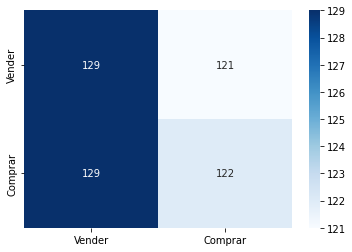

##################################################
DecisionTree
Reporte teste
              precision    recall  f1-score   support

           0       0.54      0.53      0.53       250
           1       0.54      0.54      0.54       251

    accuracy                           0.54       501
   macro avg       0.54      0.54      0.54       501
weighted avg       0.54      0.54      0.54       501



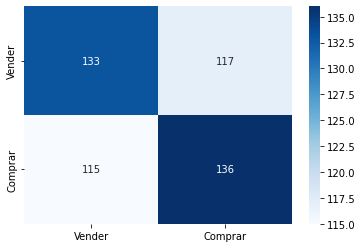

##################################################
RedeNeural
Reporte teste
              precision    recall  f1-score   support

           0       0.56      0.54      0.55       250
           1       0.56      0.58      0.57       251

    accuracy                           0.56       501
   macro avg       0.56      0.56      0.56       501
weighted avg       0.56      0.56      0.56       501



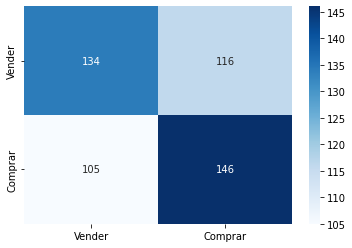

##################################################


In [42]:
df = main(scaled=True)

In [29]:
# df = main(scaled=False)

## Em comparacao entre dados com tratamento de standardScaler e sem, notou-se uma precisao melhor quando os dados nao estao com scaler para KNN e Rede Neural.

## Escolha de 3 melhores modelos para comparação

In [30]:
import numpy as np
def run_tunning_grid(X_treino, y_treino):

    n_estimators = range(100, 300, 100)
    max_features = list(range(1, 7))
    max_features = [4,5,7]
    max_features = ["auto", "sqrt", "log2"]
    # max_features.append("auto")

    precision2_score = make_scorer(precision_score, labels=[2], average='macro')
    parameters = {
        "loss":["deviance"],
        "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
        "min_samples_split": [0.05, 0.1, 0.2], #np.linspace(0.05, 0.1, 0.2),
        "min_samples_leaf": [0.05, 0.1, 0.2], #np.linspace(0.05, 0.1, 0.2),
        "max_depth":[3],
        "max_features":["log2", "sqrt"],
        "criterion": ["mae"],
        # "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
        "n_estimators":[7]
        }
    grid = GridSearchCV(
            estimator=GradientBoostingClassifier(random_state=1),
            param_grid=parameters,
            scoring=precision2_score,
            refit=False,cv=10, n_jobs=-1
    )

    return grid.fit(X_treino, y_treino)   

In [31]:
 # split database train and test
X_treino, X_teste, y_treino, y_teste = split_dados(df)
# resultado_grid = run_tunning_grid(X_treino, y_treino)

print("Ajuste feito")

# print(resultado_grid.best_params_)
# modelo_tunado = resultado_grid.best_estimator_
# previsoes = modelo_tunado.predict(X_teste)

# avaliar(y_teste, previsoes, "RandomForest Tunado")

len(X_treino)=1166 len(X_teste)=501 len(y_treino)=1166 len(y_teste)=501
Ajuste feito


In [32]:
resultado_grid.best_params_

NameError: name 'resultado_grid' is not defined

In [ ]:
resultado_grid.best_score_

0.0

/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:1280: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterio

gradient boost tunned
Reporte teste
              precision    recall  f1-score   support

           0       0.52      0.48      0.50       250
           1       0.52      0.56      0.54       251

    accuracy                           0.52       501
   macro avg       0.52      0.52      0.52       501
weighted avg       0.52      0.52      0.52       501



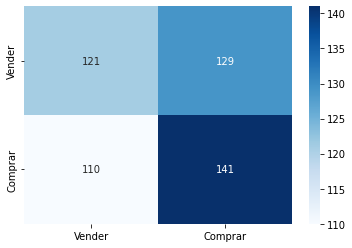

##################################################


In [ ]:
# modelo = GradientBoostingClassifier(min_samples_split=0.1,
#                                      min_samples_leaf=0.1, 
#                                      learning_rate=0.025, 
#                                      max_depth=5, 
#                                      max_features="sqrt",
#                                      criterion="friedman_mse",
#                                      random_state=1)

# modelo = GradientBoostingClassifier(min_samples_split=0.05,
#                                      min_samples_leaf=0.05, 
#                                      learning_rate=0.1, 
#                                      max_depth=3, 
#                                      max_features="sqrt",
#                                      criterion="mae",
#                                      random_state=1)

modelo = GradientBoostingClassifier(min_samples_split=0.05,
                                     min_samples_leaf=0.05, 
                                     learning_rate=0.01, 
                                     max_depth=3, 
                                     max_features="log2",
                                     criterion="mae",
                                     random_state=1)

modelo.fit(X_treino, y_treino)
previsoes = modelo.predict(X_teste)
avaliar(y_teste, previsoes, "gradient boost tunned")

